<div class="row">
  <div class="column">
<img align="left" width="200" height="42" src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png" />  </div>
  <div class="column">
<img align="right" width="120" height="42" src="https://upload.wikimedia.org/wikipedia/commons/b/bd/CC-BY-NC-SA.svg"/>  </div>
</div>

Jean-Christophe Loiseau  
Maître de Conférences  
&#128231; : jean-christophe.loiseau@ensam.eu  
&#128197; : 13 Mai 2022

In [1]:
import numpy as np
from scipy.linalg import svd, eig, eigvals, cholesky, pinv

import matplotlib.pyplot as plt
%matplotlib inline

# -->
from scipy.signal import dlti, dlsim
from scipy.linalg import solve_discrete_lyapunov

# Introduction to model order reduction and system identification

This notebook is an introduction to model order reduction and system identification for input-output linear time-invariant (LTI) dynamical systems.
It is used as supplementary material for the short course **On the importance of low-dimensional structures for data-driven modeling** given during the *Semaine d'immersion à l'IA* at the [Sorbonne Center for Artificial Intelligence](https://scai.sorbonne-universite.fr/).
As for the other notebooks included in this [GitHub repository](https://github.com/loiseaujc/scai_tutorials_mai_2022), its aim is to illustrate how ubiquituous the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) is.

## Some definitions

Let us start by giving some definitions.
Throughout this notebook, we'll consider linear dynamical systems of the general form

$$
\begin{aligned}
    \mathbf{x}_{i+1} & = \mathbf{Ax}_k + \mathbf{Bu}_k \\
    \mathbf{y}_k & = \mathbf{Cx}_k + \mathbf{Du}_k
\end{aligned}
$$

where $\mathbf{x} \in \mathbb{R}^n$ denotes the state vector of the system, $\mathbf{u} \in \mathbb{R}^p$ represents the input, and $\mathbf{y} \in \mathbb{R}^q$ is the vector of measurements collected from different sensors.
The matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$ describes the natural dynamics of the system, while $\mathbf{B} \in \mathbf{R}^{n \times p}$ describes how the input $\mathbf{u}$ influences the state $\mathbf{x}$ and is sometimes called the *input-to-state matrix*.
Similarly, the matrix $\mathbf{C} \in \mathbb{R}^{q \times n}$ describes the type of measurements being collected, while $\mathbf{D} \in \mathbb{R}^{q \times p}$ describes how the input might directly influence the output.
Without loss of generality, we'll assume in the rest of this notebook that $\mathbf{D} = \mathbf{0}$.

By the end of this notebook, two majors techniques will be introduced.
The first one is a *projection-based technique*.
Its aim is to obtain a reduced-order model (i.e. a proxy system with $r \ll n$ states) by making use of the explicit knowledge of the $\mathbf{A}$, $\mathbf{B}$, and $\mathbf{C}$ matrices.
The second approach is a *system identification technique*.
Its goal is similar to the first approach, albeit we no longer assume that $\mathbf{A}$, $\mathbf{B}$, and $\mathbf{C}$ are known.
Instead, we'll try to identify a reduced-order model solely based on input-output data, i.e. on time series of the input $\mathbf{u}$ and the corresponding output $\mathbf{y}$.
Both of these approaches rely on fundamental objects from control theory that we now define.

### The controlability $\mathcal{R}(\mathbf{A}, \mathbf{B})$ and observability $\mathcal{O}(\mathbf{A}, \mathbf{C})$ matrices

The controlability (or reachability) matrix of the considered input-output system is defined as

$$
    \mathcal{R}(\mathbf{A}, \mathbf{B})
    =
    \begin{bmatrix}
        \mathbf{B} & \mathbf{AB} & \mathbf{A}^2 \mathbf{B} & \cdots & \mathbf{A}^k\mathbf{B} & \cdots
    \end{bmatrix},
$$

while the observability matrix is defined as

$$
    \mathcal{O} (\mathbf{A}, \mathbf{C})
    =
    \begin{bmatrix}
    \mathbf{C} \\ \mathbf{CA} \\ \mathbf{CA}^2 \\ \vdots \\ \mathbf{CA}^k \\ \vdots
    \end{bmatrix}.
$$

These two matrices formally have an infinite number of columns or rows, depending on which is considered.
They are probably the most important building blocks of many concepts and techniques used in control and system identification theories.

The columns of $\mathcal{R}(\mathbf{A}, \mathbf{B})$ spans all the states which are reachable, i.e. the configurations in which the system can be driven given the appropriate input sequence.
If these columns span all of $\mathbb{R}^n$, the pair $(\mathbf{A},\mathbf{B})$ is controllable.
Otherwise, it is not controllable, meaning that some particular configurations cannot be achieved no matter the input sequence considered.
Similarly, the rowspan of $\mathcal{O}(\mathbf{A}, \mathbf{C})$ describes all the states which can be correctly inferred from time series of the measurements $\mathbf{y}$.
If these rows span all of $\mathbb{R}^n$, the pair $(\mathbf{A}, \mathbf{C})$ is observable.
Otherwise, it is not, meaning that some particular configurations cannot be inferred from the measurements no matter how long of a time series we consider.


### The adjoint system

Looking at these observability and reachability matrices, one might realize that $\mathcal{O}^T$ appears as the controlability matrix of a new system

$$
\mathbf{z}_{i+1} = \mathbf{A}^T \mathbf{z}_i + \mathbf{C}^T \mathbf{v}_i.
$$

This new system, along with the measurement equation

$$
\mathbf{w}_i = \mathbf{B}^T \mathbf{z}_i + \mathbf{D}^T \mathbf{v}_i,
$$

is known as the **adjoint system**, or the *dual*.
It is another key concept in control and optimization theory whose discussion would bring us down the rabbit hole.
Suffice to say for the moment that we'll need it as some point.


### The controlability $\mathbf{W}_{\mathcal{C}}$ and observability $\mathbf{W}_{\mathbf{O}}$ gramians

The controllability $\mathcal{R}$ and observability $\mathcal{O}$ matrices provide a binary test.
If $\textrm{rank } \mathcal{R} = n$ (resp. $\textrm{rank } \mathcal{O} = n$), the system is controllable (resp. observable), otherwise it is not.
Although valuable, such binary test does not inform us about *how controllable/observable* the system.
Are some configurations easier to reach or to observe than others?
A finer grain description is given by the so-called controlability and observability gramians.
These are defined as

$$
    \mathbf{W}_{\mathcal{C}} = \mathcal{R} \mathcal{R}^T \quad \text{and} \quad \mathbf{W}_{\mathcal{O}} = \mathcal{O}^T \mathcal{O}.
$$

Both of them are $n \times n$ symmetric positive-definite matrices.
Let us introduce their eigendecomposition

$$
    \mathbf{W}_{\mathcal{C}} = \mathbf{U}_{\mathcal{C}} \boldsymbol{\Sigma}_{\mathcal{C}}^2 \mathbf{U}^T_{\mathcal{C}} \quad \textrm{and} \quad \mathbf{W}_{\mathcal{O}} = \mathbf{U}_{\mathcal{O}} \boldsymbol{\Sigma}_{\mathcal{O}}^2 \mathbf{U}_{\mathcal{O}}^T,
$$

where $\boldsymbol{\Sigma}_{\mathcal{C}}$ and $\boldsymbol{\Sigma}_{\mathcal{O}}$ are diagonal matrices with non-negative entries in decreasing order.
The main interest of this eigendecomposition is that $\mathbf{U}_{\mathcal{C}}$ now provides a basis to represent the state of the system, where the columns of $\mathbf{U}_{\mathcal{C}}$ are ordered from the most controlable (i.e. easier to achieve) configuration to the least controlable one.
Similarly, the columns of $\mathbf{U}_{\mathcal{O}}$ provides another basis to represent the state, where its columns are ordered from the most easily observable configuration to the least observable one (i.e. the state hardest to infer given our choice of measurements).

Although empirical (i.e. approximate) Gramians can be computed from simulation data, it can be shown that, for the discrete-time system considered, these Gramians are solutions to the following Lyapunov equation

$$
    \begin{aligned}
    \mathbf{W}_{\mathcal{C}} - \mathbf{A} \mathbf{W}_{\mathcal{C}} \mathbf{A}^T & = \mathbf{BB}^T, \\
    \mathbf{W}_{\mathcal{O}} - \mathbf{A}^T \mathbf{W}_{\mathcal{O}} \mathbf{A} & = \mathbf{C}^T \mathbf{C}.
    \end{aligned}
$$

The algorithms to solve these equations are beyond the scope of this short introduction.
For moderate systems (i.e. $n < 1000$), we'll use the function `solve_discrete_lyapunov` from the module `scipy.linalg`.

### The Hankel operator $\mathcal{H}$ and the impulse response

The last two pieces we need are the **impulse response** and the closely related **Hankel operator**.
As its name states, the impulse reponse system of the system is the response of the system to an impulse.
Consider for now a single input/single output (SISO) system

$$
\begin{aligned}
    \mathbf{x}_{i+1} & = \mathbf{Ax}_i + \mathbf{B}u_i \\
    y_i & = \mathbf{Cx}_i + \mathbf{D} u_i
\end{aligned}
$$

where $\mathbf{B} \in \mathbb{R}^{n \times 1}$, $\mathbf{C} \in \mathbb{R}^{1 \times n}$ and $\mathbf{D} \in \mathbb{R}$.
An impulse is defined as

$$
    u_i
    =
    \begin{cases}
        1 \quad \textrm{for } i = 0 \\
        0 \quad \textrm{otherwise.}
    \end{cases}
$$

We'll assume furthermore that $\mathbf{x}_0 = \mathbf{0}$.
From there, it is easy to show by recurrence that the response of the system to this input is given by

$$
    y_0 = \mathbf{D}, \quad y_1 = \mathbf{CB}, \quad y_2 = \mathbf{CAB}, \quad y_3 = \mathbf{CA}^2 \mathbf{B}, \quad \cdots, \quad y_i = \mathbf{CA}^{i-1} \mathbf{B}, \cdots
$$

The vector $\mathbf{h}$ defined as

$$
    \mathbf{h}
    =
    \begin{bmatrix}
    \mathbf{D} & \mathbf{CB} & \mathbf{CAB} & \mathbf{CA}^2 \mathbf{B} & \cdots & \mathbf{CA}^{i-1}\mathbf{B} & \cdots
    \end{bmatrix}
$$

is precisely the impulse response of the response.
The entry $\mathbf{h}_i$ is known as the i-th *Markov parameter* of the system.
One key property of this impulse reponse is that it is invariant with respect to an invertible change of coordinates.
Another major interest is that, provided $\mathbf{A}$ is stable (i.e. all of its eigenvalues are inside the unit circle), this impulse response can be relatively easily obtained experimentally.

An operator closely related to this impulse response is the so-called *Hankel operator*.
It is defined as

$$
    \begin{aligned}
        \mathcal{H} & = \mathcal{OR} \\
        & = \begin{bmatrix} \mathbf{C} \\ \mathbf{CA} \\ \mathbf{CA}^2 \\ \vdots \end{bmatrix}
        \begin{bmatrix} \mathbf{B} & \mathbf{AB} & \mathbf{A}^2 \mathbf{B} & \cdots \end{bmatrix}
    \end{aligned}
$$

Simple algebraic manipulations show that this operator is an infinite dimensional *Hankel matrix* whose entries are given by the Markov parameters of the system.
It can be shown moreover that, while the singular values of the observability and controlability gramians depend on the coordinate system considered, the singular values $\boldsymbol{\Sigma}$ of the Hankel operator are an invariant of the system.
These are simply known as the *Hankel singular values* of the system and are used to quantify various properties of the system.
It can be shown additionaly that these Hankel singular values are also given by

$$
\sigma_i = \sqrt{ \lambda_i(\mathbf{W}_{\mathcal{C}} \mathbf{W}_{\mathcal{O}})},
$$

thus relating the Hankel operator and the controllability and observability gramians.
For an in-depth discussion about HSVD, readers are referred to the excellent book [Approximation of large-scale dynamical systems](https://epubs.siam.org/doi/book/10.1137/1.9780898718713) by A. C. Antoulas.

---

We have now defined all of the basic tools we'll need for our purpose.
Let's move on to model order reduction and system identification.
For the sake of simplicity, we'll consider in the rest of this notebook a random (stable) system.
The function below creates such a system where $n$ is the number of degrees of freedom, $p$ the number of input, and $q$ the number of output.

In [2]:
def rss(n, p, q):
    """
    Generates a random state space model of a (stable) discrete
    time linear system with n degrees of freedom, p input and q
    output.
    
    INPUT
    -----
    
    n : int
        Number of degrees of freedom in the system.
        
    p : int
        Number of input to the system.
        
    q : int
        Number of output of the system.
        
    RETURN
    ------
    
    sys : scipy data structure for discrete-time linear system.
          State space model.
    
    """
    
    ############################
    #####     DYNAMICS     #####
    ############################
    
    # --> Generate a random linear dynamics matrix.
    A = np.random.randn(n, n)
    
    # --> Compute its eigendecomposition.
    Λ, V = eig(A)
    
    # --> Forces the eigenvalues to be inside the unit circle.
    Λ = 0.9 * Λ / np.abs(Λ).max()
    
    # --> Reconstruct the stable dynamics matrix.
    A = (V @ np.diag(Λ) @ pinv(V)).real
    
    #########################################
    #####     INPUT/OUTPUT MATRICES     #####
    #########################################
    
    # --> Input-to-state matrix.
    B = np.random.randn(n, p)
    
    # --> State-to-output matrix.
    C = np.random.randn(q, n)
    
    # --> Input-to-state matrix.
    D = np.zeros((q, p))
    
    return dlti(A, B, C, D)

In [3]:
# --> Generate a random state-space model.
sys = rss(n:=20, p:=2, q:=2)

In [4]:
# --> Extract the matrices of the system.
A, B, C, D = sys.A, sys.B, sys.C, sys.D

## Projection-based reduced-order modeling

Although numerous questions remains open, projection-based techniques are a rather well developed and understood area of applied mathematics for reduced-order modeling.
They assume that the matrices $\mathbf{A}$, $\mathbf{B}$, and $\mathbf{C}$ are known explicitely and derive the reduced-order model directly from these.
Numerous variants exist, forming the work horses of reduced-order modeling.
Hereafter, we'll focus our attention of **balanced truncation** and **balanced proper orthogonal decomposition**.

### Balanced Truncation

Let us consider once again the observability and controllability gramians

$$
\mathbf{W}_{\mathcal{O}} = \mathcal{O}^T \mathcal{O} \quad \textrm{and} \quad \mathbf{W}_{\mathcal{C}} = \mathcal{RR}^T.
$$

As stated ealier, their singular value decomposition provides a basis for the most observable (resp. controllable) configurations.
One major issue in using either of these basis (e.g. $\mathbf{U}_{\mathcal{C}}$ or $\mathbf{U}_{\mathcal{O}}$) is that the most controllable configurations are not necessarily the easiest to observe, and vice versa.
As an example, consider the flow past a two-dimensional cylinder.
We'll assume that actuators are being mounted on the cylinder while sensors are placed far downstream in the wake.
The most controllable modes would correspond to vortical structures in the vicinity of the cylinder.
These structures may not however be easily observable as they may be diffused as they travel downstream before reaching the sensor.
Similarly, the most observable modes correspond to the large scale vortical structures forming the von Karman vortex street.
Given our choice of actuators, these structures may however be hard to control as they have already formed before we can even observe them.

In the ideal situation, we thus would like to have a reduced representation of the state of the system describing the amplitude of the modes which are equally observable and controllable.
Indeed, modes that are very hard to control although very easy to observe are of little interest to design a reduced-order control system, and similarly for modes which are easy to control but cannot be observed (or hardly) given our choice of sensors.
A good trade-off is given by **balanced truncation**.
Given the observability and controllability Gramians, we wish to find two basis such that

$$
\mathbf{P}^T \mathbf{W}_{\mathcal{O}} \mathbf{P} = \mathbf{Q}^T \mathbf{W}_{\mathcal{C}} \mathbf{Q} = \boldsymbol{\Sigma}
$$

where $\boldsymbol{\Sigma}$ are the Hankel singular values of the system.
To remove any ambiguity, we'll assume furthermore that $\mathbf{P}$ and $\mathbf{Q}$ are *bi-orthogonal*, i.e. $\mathbf{P}^T \mathbf{Q} = \mathbf{I}$.
For a given rank $r$ of the reduced-order model, it can be shown that these matrices $\mathbf{P}$ and $\mathbf{Q}$ are given by the first $r$ eigenvectors of the following generalized eigenproblem

$$
\begin{bmatrix}
    \mathbf{W}_{\mathcal{O}} & \mathbf{0} \\
    \mathbf{0} & \mathbf{W}_{\mathcal{C}}
\end{bmatrix}
\begin{bmatrix}
\mathbf{P} \\ \mathbf{Q}
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{0} & \mathbf{I} \\
\mathbf{I} & \mathbf{0}
\end{bmatrix}
\begin{bmatrix}
\mathbf{P} \\ \mathbf{Q}
\end{bmatrix}
\boldsymbol{\Sigma}.
$$

Note that solving this generalized eigenproblem for a large-scale system is impractical as it involves matrices of dimension $2n \times 2n$.
By using simple linear algebra tricks, it can be solved more efficiently by using the Cholesky decomposition of the Gramians.
This is what is being done in the function below.
For a detailled description of the algorithm, please refer to the book by Antoulas.

In [5]:
def balanced_truncation(sys, rank):
    """
    Given a system, this function computes the two rank r basis needed
    for balanced truncation.
    
    INPUT
    -----
        
    sys : scipy data structure for discrete-time linear system.
          State space model of the system we wish to reduce.
          
    rank : int
           Rank of the desired truncation.
          
    OUTPUT
    ------
    
    V, W : numpy array of size (n, rank).
           The rank r basis resulting from balanced truncation.
          
    """
    
    # --> Extract the matrices of the system.
    A, B, C = sys.A, sys.B, sys.C
    
    # --> Compute the Observability Gramian
    Wo = solve_discrete_lyapunov(A.T, C.T @ C)
    L = cholesky(Wo, lower=True)
    
    # --> Compute the Controlability Gramian
    Wc = solve_discrete_lyapunov(A, B @ B.T)
    U = cholesky(Wc, lower=True)
    
    # --> Compute the SVD of the cross Gramian.
    Z, Σ, Yt = svd(U.T @ L, full_matrices=False)
    Y = Yt.T
    
    # --> Truncate
    Z, Σ, Y = Z[:, :rank], Σ[:rank], Y[:, :rank]
    
    # --> Construct the two basis for balanced truncation.
    V = U @ Z @ np.diag(1/np.sqrt(Σ))
    W = L @ Y @ np.diag(1/np.sqrt(Σ))
    
    return V, W

### Balanced Proper Orthogonal Decomposition

Although the computational cost of balanced truncation can be reduced by making clever usage of different linear algebra techniques, it still necessitate the explicit computation of the Gramians in the first place.
These computations require $\mathcal{O}(n^3)$ operations, something utterly impossible for large-scale dynamical system.
An alternative approach based on approximation of the Gramians for simulation data has been proposed by C. Rowley in [Model order reduction for fluids using Balanced Proper Orthogonal Decomposition](https://cwrowley.princeton.edu/papers/bt_ijbc3.pdf).
This algorithm is implemented below.

In [6]:
def Controlability(A, B, n=100):
    """
    Compute the first n columns of the controlability matrix of the pair (A, B).
    
    INPUT
    -----
    
    A : numpy array of size (n, n)
        Matrix describing the natural dynamics of the system.
        
    B : numpy array of size (n, p)
        Matrix describing the actuators of the system.
        
    n : int (default n = 100)
        Number of block of columns of the controllability matrix to compute.
        
    OUTPUT
    ------
    
    R : numpy array of size (n, n x q)
        Controllability matrix of the system.
    
    """    
    
    # --> Compute the controlability matrix.
    R = np.hstack([ np.linalg.matrix_power(A, k) @ B for k in range(n) ])
    
    return R

In [7]:
def Observability(A, C, n=100):
    """
    Compute the observability matrix of the pair (A, C).
    See Controlability for more details.
    """
    return Controlability(A.T, C.T, n).T

In [8]:
def BPOD(sys, rank, n=200):
    """
    Implementation of Balanced Proper Orthogonal Decomposition [1].
    
    INPUT
    -----
    
    sys : scipy data structure for discrete-time linear system.
          System to which we wish to apply BPOD.
          
    rank : int
           Rank of the BPOD bases.
           
    n : int (default 200)
        Number of blocks to compute for the reachability and observability matrices.
        
    OUTPUT
    ------
    
    P, Q : scipy array, size (n, rank)
           BPOD bases.
           
    References
    ----------
    
    [1] C. Rowley. Model order reduction for fluids using Balanced Proper
    Orthogonal Decomposition. 2005.
    
    """
    
    # --> Extract the matrices of the system.
    A, B, C = sys.A, sys.B, sys.C
    
    # --> Compute the controllability and observation matrices.
    Ctrb = Controlability(A, B, n)
    Obs = Observability(A, C, n)

    # --> SVD of the low-dimensional cross gramian.
    H = Obs @ Ctrb
    U, Σ, Vt = svd(H, full_matrices=False) ; V = Vt.T
    
    # --> Truncate the basis.
    U, Σ, V = U[:, :rank], Σ[:rank], V[:, :rank]
    
    # --> Compute the BPOD bases.
    P = Ctrb @ V @ np.diag(1/np.sqrt(Σ))
    Q = Obs.T @ U @ np.diag(1/np.sqrt(Σ))
    
    return P, Q

### Comparisons

Let us now compare the reduced-order models obtained from BT and BPOD with the original high-dimensional one.
In both cases, we'll assume that the input-output properties of the original high-dimensional can be approximated by a low-order system of rank 5.

In [9]:
# --> Compute the bases from balanced truncation.
V_bt, W_bt = balanced_truncation(sys, rank:=6)

In [10]:
# --> Compute the bases from BPOD.
V_bpod, W_bpod = BPOD(sys, rank)

In [11]:
# --> Build the reduced-order model from BT.
Â, B̂, Ĉ, D̂ = W_bt.T @ A @ V_bt, W_bt.T @ B, C @ V_bt, D
bt_rom = dlti(Â, B̂, Ĉ, D̂)

In [12]:
# --> Build the reduced-order model from BPOD.
Â, B̂, Ĉ, D̂ = W_bpod.T @ A @ V_bpod, W_bpod.T @ B, C @ V_bpod, D
bpod_rom = dlti(Â, B̂, Ĉ, D̂)

Let us start by comparing the Hankel singular values of the different models.

In [13]:
def HSVD(sys):
    """
    Computation of the Hankel singular values of the system based
    on the eigenvalues of Gramian product.
    
    INPUT
    -----
    
    sys : scipy data structure for discrete-time linear system.
          System whose HSVD we wish to compute.
          
    OUTPUT
    ------
    
    Σ : numpy array, size (n,)

    """
    
    # --> Extract the matrices of the system.
    A, B, C = sys.A, sys.B, sys.C
    
    # --> Compute the Gramians.
    Wc = solve_discrete_lyapunov(A, B @ B.T)
    Wo = solve_discrete_lyapunov(A.T, C.T @ C)
    
    # --> Compute the Hankel singular values.
    Σ = np.sqrt( np.abs(eigvals(Wc @ Wo)) ) ; Σ.sort() ; Σ = Σ[::-1]
       
    return Σ

In [14]:
# --> Hankel singular values of the original system.
Σ = HSVD(sys)

# --> Hankel singular values of the reduced-order model obtained from Balanced Truncation.
Σ_bt = HSVD(bt_rom)

# --> Hankel singular values of the reduced-order model obtained from BPOD.
Σ_bpod = HSVD(bpod_rom)

[(-0.5, 18.734187731563086), Text(0, 0.5, 'Hankel singular values')]

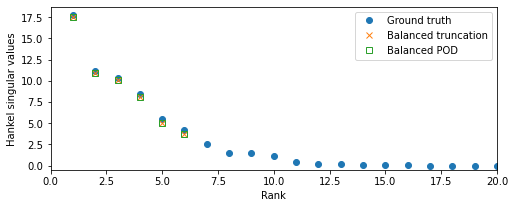

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(np.arange(1, len(Σ)+1), Σ, 'o', label="Ground truth")

ax.plot(np.arange(1, len(Σ_bt)+1), Σ_bt, "x", label="Balanced truncation")

ax.plot(np.arange(1, len(Σ_bpod)+1), Σ_bpod, "s", mfc="none", label="Balanced POD")

ax.legend()

ax.set(xlim=(0, 20), xlabel="Rank")
ax.set(ylim=(-0.5, Σ.max() + 1), ylabel="Hankel singular values")

As expected, both reduced order models have Hankel singular values closely approximating the leading ones of the original system.
Such an agreement ensures that, despite being lower dimensional, both reduced-order models preserve most of the input-output properties of the original system.
This can be verified by looking at their impulse responses.

In [16]:
# --> Impulse response of the original system.
_, h = sys.impulse()

# --> Impulse response of the reduced-order model obtained from Balanced Truncation.
_, h_bt = bt_rom.impulse()

# --> Impulse response of the reduced-order model obtained from Balanced POD.
_, h_bpod = bpod_rom.impulse()

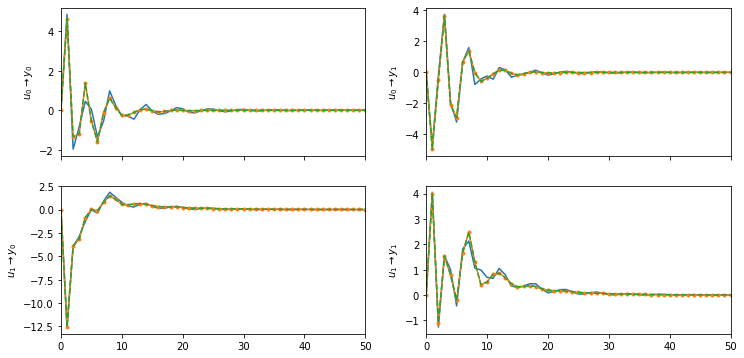

In [17]:
fig, axes = plt.subplots(p, q, figsize=(12, 6), sharex=True)

for i in range(p):
    for j in range(q):

        axes[i, j].plot(h[i][:, j])
        axes[i, j].plot(h_bt[i][:, j], '.-')
        axes[i, j].plot(h_bpod[i][:, j], '--')
        
        axes[i, j].set(xlim=(0, 50), ylabel=r"$u_{0} \rightarrow y_{1}$".format(i, j))

Once again, you should observe a relatively good agreement between the impulse reponses of the different systems.
One major advantage of using reduced-order models for control purposes is that, because of their smaller dimension, all of the computations are accelerated.
This acceleration is a key enabler of real-time control, an over-arching goal in engineering.
Note moreover that, even though the correspondence may not be perfect, techniques such as *robust control* or *model predictive control* can still work with these imperfect yet simple models to control possibily extremely complex structures in mechanical engineering or flows in fluid dynamics.

---

## System identification

Balanced truncation and Balanced POD are powerful techniques to obtain reduced-order models.
One major limitation however is that both of these require explicit knowledge of the underlying high-dimension system.
Such knowledge may not however however be easily accessible, particularly when considering real systems for which only input-output data is available.
System identification is field of applied mathematics that precisely tries to overcome this limitation.
Its goal is to *identify* a model of the system based solely on the available input-output data.
Numerous such techniques exist.
In the rest of this notebook, we'll focus our attention on one of the simplest yet most used of these techniques, namely the **EigenRealization algorithm** (ERA).

### EigenRealization algorithm

ERA aims at identifying a realization $(\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D})$ solely from input-output data.
In particular, it needs access only to the impulse response of the system, something which can be done experimentally.
Let us consider an unknown linear system

$$
\begin{aligned}
    \mathbf{x}_{i+1} & = \mathbf{Ax}_i + \mathbf{Bu}_i \\
    \mathbf{y}_i & = \mathbf{Cx}_i + \mathbf{Du}_i.
\end{aligned}
$$

As stated before, $\mathbf{A}$, $\mathbf{B}$, $\mathbf{C}$, $\mathbf{D}$ and $\mathbf{x}$ are unknown.
The only information we have access to is how the response $\mathbf{y}$ of the system to an input $\mathbf{u}$.
We'll restrict ourselves in particular to the impulse reponse.
Let's assume for the sake of simplicity that we have access to the first ten elements of this impulse response, i.e.

$$
\mathbf{h}
=
\begin{bmatrix}
    \mathbf{y}_1 & \mathbf{y}_2 & \mathbf{y}_3 & \cdots & \mathbf{y}_{10}
\end{bmatrix}.
$$

From this time series, we can construct the (block) Hankel matrix

$$
\mathbf{H}
=
\begin{bmatrix}
\mathbf{y}_1 & \mathbf{y}_2 & \mathbf{y}_3 & \mathbf{y}_4 & \mathbf{y}_5 \\
\mathbf{y}_2 & \mathbf{y}_3 & \mathbf{y}_4 & \mathbf{y}_5 & \mathbf{y}_6 \\
\mathbf{y}_3 & \mathbf{y}_4 & \mathbf{y}_5 & \mathbf{y}_6 & \mathbf{y}_7 \\
\mathbf{y}_4 & \mathbf{y}_5 & \mathbf{y}_6 & \mathbf{y}_7 & \mathbf{y}_8 \\
\mathbf{y}_5 & \mathbf{y}_6 & \mathbf{y}_7 & \mathbf{y}_8 & \mathbf{y}_9 \\
\end{bmatrix}.
$$

Plugging-in the definition of the impulse response, this matrix can be re-written as

$$
\mathbf{H}
=
\begin{bmatrix}
    \mathbf{CB} & \mathbf{CAB} & \mathbf{CA}^2 \mathbf{B} & \mathbf{CA}^3 \mathbf{B} & \mathbf{CA}^4 \mathbf{B} \\
    \mathbf{CAB} & \mathbf{CA}^2 \mathbf{B} & \mathbf{CA}^3 \mathbf{B} & \mathbf{CA}^4 \mathbf{B} & \mathbf{CA}^5 \mathbf{B} \\
    \mathbf{CA}^2 \mathbf{B} & \mathbf{CA}^3 \mathbf{B} & \mathbf{CA}^4 \mathbf{B} & \mathbf{CA}^5 \mathbf{B} & \mathbf{CA}^6 \mathbf{B} \\
    \mathbf{CA}^3 \mathbf{B} & \mathbf{CA}^4 \mathbf{B} & \mathbf{CA}^5 \mathbf{B} & \mathbf{CA}^6 \mathbf{B} & \mathbf{CA}^7 \mathbf{B} \\
    \mathbf{CA}^4 \mathbf{B} & \mathbf{CA}^5 \mathbf{B} & \mathbf{CA}^6 \mathbf{B} & \mathbf{CA}^7 \mathbf{B} & \mathbf{CA}^8 \mathbf{B} \\
\end{bmatrix}.
$$

It should be pretty obvious that this matrix can be factorized as

$$
\mathbf{H}
=
\begin{bmatrix}
\mathbf{C} \\ \mathbf{CA} \\ \mathbf{CA}^2 \\ \mathbf{CA}^3 \\ \mathbf{CA}^4
\end{bmatrix}
\begin{bmatrix}
    \mathbf{B} & \mathbf{AB} & \mathbf{A}^2 \mathbf{B} & \mathbf{A}^3 \mathbf{B} & \mathbf{A}^4 \mathbf{B}
\end{bmatrix}
$$

where we recognize the factorization $\mathbf{H} = \mathcal{O} \mathcal{R}$, with $\mathcal{O}$ and $\mathcal{R}$ being the observability and reachability matrices of the unknown system.
Introducing the singular value decomposition $\mathbf{H} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$, we can recognize that this factorization implies

$$
\mathcal{O} = \mathbf{U} \boldsymbol{\Sigma}^{\frac12} \quad \textrm{and} \quad \mathcal{R} = \boldsymbol{\Sigma}^{\frac12} \mathbf{V}^T.
$$

From there, the $\mathbf{B}$ and $\mathbf{C}$ matrices can be directly identified as being the first $p$ columns of $\mathcal{R}$ and $q$ rows of $\mathcal{O}$, respectively.
Moreover, $\mathbf{H}$ being a finite-dimensional representation of the Hankel operator $\mathcal{H}$, its singular values $\boldsymbol{\Sigma}$ are approximation of the true Hankel singular values of the system.

Now that $\mathbf{B}$ and $\mathbf{C}$ have been identified (and note that $\mathbf{D} = \mathbf{h}_0$), let us turn our attention to the identification of the matrix $\mathbf{A}$.
For that purpose, consider a shifted Hankel matrix constructed as

$$
\bar{\mathbf{H}}
=
\begin{bmatrix}
\mathbf{y}_2 & \mathbf{y}_3 & \mathbf{y}_4 & \mathbf{y}_5 & \mathbf{y}_6 \\
\mathbf{y}_3 & \mathbf{y}_4 & \mathbf{y}_5 & \mathbf{y}_6 & \mathbf{y}_7 \\
\mathbf{y}_4 & \mathbf{y}_5 & \mathbf{y}_6 & \mathbf{y}_7 & \mathbf{y}_8 \\
\mathbf{y}_5 & \mathbf{y}_6 & \mathbf{y}_7 & \mathbf{y}_8 & \mathbf{y}_9 \\
\mathbf{y}_6 & \mathbf{y}_7 & \mathbf{y}_8 & \mathbf{y}_9 & \mathbf{y}_{10} \\
\end{bmatrix}.
$$

Using once again the definition of the impulse response, this matrix can be factorized as

$$
\bar{\mathbf{H}}
=
\begin{bmatrix}
\mathbf{C} \\ \mathbf{CA} \\ \mathbf{CA}^2 \\ \mathbf{CA}^3 \\ \mathbf{CA}^4
\end{bmatrix}
\mathbf{A}
\begin{bmatrix}
    \mathbf{B} & \mathbf{AB} & \mathbf{A}^2 \mathbf{B} & \mathbf{A}^3 \mathbf{B} & \mathbf{A}^4 \mathbf{B}
\end{bmatrix}
$$

Hence, the matrix $\mathbf{A}$ can be recovered from the low-rank factorization of $\mathbf{H}$ and from $\bar{\mathbf{H}}$ as 

$$
\mathbf{A} = \mathcal{O}^{\dagger} \bar{\mathbf{H}} \mathcal{R}^{\dagger}
$$

where $\mathcal{O}^{\dagger}$ and $\mathcal{R}^{\dagger}$ denote the Moore-Penrose pseudoinverse of $\mathcal{O}$ and $\mathcal{R}$, respectively.
This is as simple as it gets.
QED.

Let's now move on with the implementation.
This is done in the routine below.

In [18]:
def ERA(sys, rank, n=200):
    
    #####
    #####     IN PRACTICE, THESE WOULD BE DATA COLLECTED FROM AN EXPERIMENT
    #####
    
    # --> Extract the matrices.
    A, B, C, D = sys.A, sys.B, sys.C, sys.D
    
    # --> Get the number of inputs and outputs of the system.
    p, q = B.shape[1], C.shape[0]
    
    # --> Compute the impulse of the system.
    h = np.hstack([C @ np.linalg.matrix_power(A, i) @ B for i in range(n)])
    
    #####
    #####     EIGENREALIZATION ALGORITHM
    #####
    
    # --> Construct the Hankel matrix.
    H = np.zeros( (q*(n//2), p*(n//2)) )
    
    j = 0
    for i in range(0, H.shape[0], q):
        H[i:i+q, :] = h[:, j:H.shape[1]+j]
        j += p
        
    # --> Compute its low-rank factorization.
    U, Σ, Vt = svd(H, full_matrices=False)
    
    # --> Truncate
    U, Σ, Vt = U[:, :rank], Σ[:rank], Vt[:rank]
    
    # --> Construct the Observability and Controllability matrices.
    O, R = U @ np.diag(np.sqrt(Σ)), np.diag(np.sqrt(Σ)) @ Vt
    
    # --> Identify the B and C matrices.
    B, C = R[:, :p], O[:q]
    
    # --> Construct the second Hankel matrix.
    H = np.zeros( (q*(n//2), p*(n//2)) )
    
    j = p
    for i in range(0, H.shape[0], q):
        H[i:i+q, :] = h[:, j:H.shape[1]+j]
        j += p

    # --> Identify the A matrix.
    A = pinv(O) @ H @ pinv(R)
    
    # --> Create the system.
    sys = dlti(A, B, C, np.zeros((q, p)))
    
    return sys

As before, the following cells compute the reduced-order model, evaluate its Hankel singular values and compare them against the ground truth, along with a comparison of the impulse response of the orginal system and that of the identified model.

In [19]:
# --> Identify the reduced order model.
era_sys = ERA(sys, rank)

In [20]:
# --> Compute its Hankel singular values.
Σ_era = HSVD(era_sys)

[(-0.5, 18.734187731563086), Text(0, 0.5, 'Hankel singular values')]

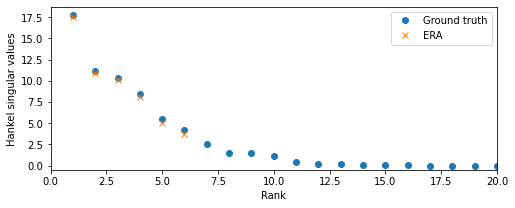

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

ax.plot(np.arange(1, len(Σ)+1), Σ, 'o', label="Ground truth")

ax.plot(np.arange(1, len(Σ_era)+1), Σ_era, "x", label="ERA")

ax.legend()

ax.set(xlim=(0, 20), xlabel="Rank")
ax.set(ylim=(-0.5, Σ.max() + 1), ylabel="Hankel singular values")

In [22]:
# --> Impulse response of the reduced-order model obtained from ERA
_, h_era = era_sys.impulse()

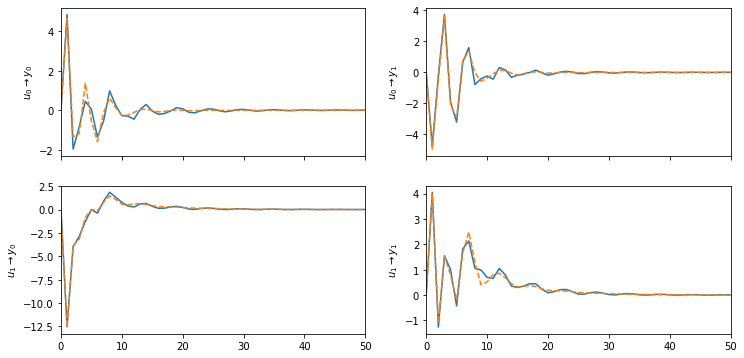

In [23]:
fig, axes = plt.subplots(p, q, figsize=(12, 6), sharex=True)

for i in range(p):
    for j in range(q):
        
        axes[i, j].plot(h[i][:, j])
        axes[i, j].plot(h_era[i][:, j], '--')
        
        axes[i, j].set(xlim=(0, 50), ylabel=r"$u_{0} \rightarrow y_{1}$".format(i, j))